In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# Data Science Project: *title*

by Millie Sohn, Markus Chu, Mhad Khan Sherwani and Sai Manas Pandrangi

## Introduction:

The gaming industry is expanding by the year, and efforts are made to study player's actions for a more targetted recruitment. To achieve this, researchers must predict what types of players are more likely to contribute to the games and determine which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how these features differ between various player types. This science project aims to specifically answer whether play hours and the player's age predict whether a player will subscribe to the Minecraft newsletter or not. In order to answer this, we used data obtained from a Minecraft server which contain specific player information and whether they subscribe to the newsletter or not. The dataset, named "players", portrays a list of players and their data (7 variables, 196 observations): player's experience (amateur, beginner, pro, regular, veteran), subscription status (TRUE: subscribed to newsletter, FALSE: not subscribed), hashed Email that uniquely identifies each player, game play hours, player name, player gender, and player age. 
The dataset reveals that 144 players are subscribed, and 52 are not. Play hours range from 0 to 223.1 hours, and age range from 8 to 50 years old.


## Methods & Results:

We will be answering our question using K-nearest neighbors Classification, tuning our model to obtain the highest prediction accuracy. 

The predictors we will be using will be strictly numerical: total time the player spent playing (hours) and player age (years). The categorical variable we will be predicting is, "subscribe" (TRUE; subscribed or FALSE; not subscribed). 
Summary of wrangled dataset:
- Male (124) females (37), Agender (2), Non-binary (15), other (1), prefer not to say (11), two-spirited (6).
- Player subscribed:(144) and not subscribed (52)
- Play hours range: 0 to 223.1 hours
- Age range: 8 to 50 y.o. Majority are 17 (75).

The players dataset was wrangled to counter some potential issues including removal of NA values. The dataset also included some outliers where some players were much older or younger than the mean (which was 20.5 years), or where players played significantly more or less hours than the mean (which was 5.9 hours). However, these outliers were kept to contain the datasize and retain information for the model to train off of. 

In [2]:
set.seed(1)

url_pl <- "https://raw.githubusercontent.com/takemil8088/ind-porject/refs/heads/main/players.csv"
players <- read_csv(url_pl) |>
select(subscribe, played_hours, Age) |>
filter(!is.na(subscribe), !is.na(played_hours), !is.na(Age)) |>
mutate(subscribe = as_factor(subscribe)) |>
rename(age = Age)

show_players <- players |> head(5)
show_players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe played_hours age
1 TRUE      30.3          9 
2 TRUE       3.8         17 
3 FALSE      0.0         17 
4 TRUE       0.7         21 
5 TRUE       0.1         21

Visualizations reveal some key information on the relationship between variables and their subscription status.
Graph 1 shows how most players with more playing hours tend to subscribe to the newsletter, and the majority are roughly ages 15 to 25 years old. Players who do not subscribe also have fewer play hours (~0-2 hours) and are all aged 17 and up.
Graph 2 reveals how majority of players aged ~10 to 30 overall subscribe to the newsletter. Older players 30 and up tend to not subscribe.

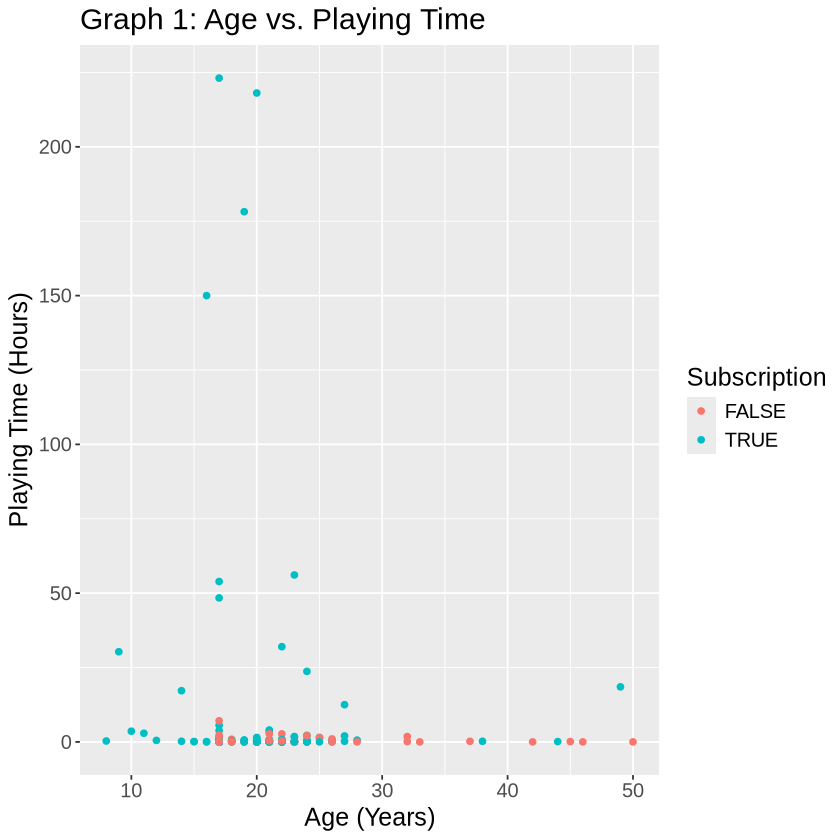

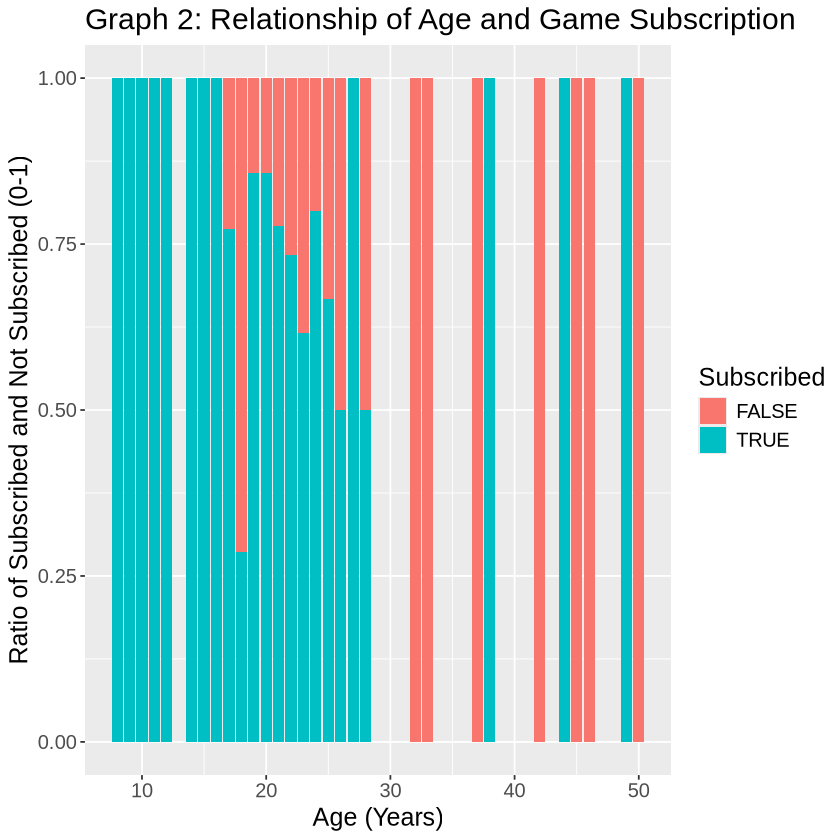

In [3]:
relation_played_hours_age <- players |>
    select(age, played_hours, subscribe) |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
    geom_point() +
    labs(x = "Age (Years)",
         y = "Playing Time (Hours)",
         colour = "Subscription",
         title = "Graph 1: Age vs. Playing Time") +
    theme(text = element_text(size = 15))

relation_played_hours_age

age_subscribe_plot <- players |>
    select(age, subscribe) |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Age (Years)",
         y = "Ratio of Subscribed and Not Subscribed (0-1)",
         fill = "Subscribed",
         title = "Graph 2: Relationship of Age and Game Subscription") +
    theme(text = element_text(size = 15))

age_subscribe_plot

To train our Knn model to obtain higher accuracy, we split our data into 75% for training and 25% for testing. 

In [4]:
split <- initial_split(players, prop = 0.75, strata = subscribe)
train <- training(split)
test <- testing(split)

To choose the best K that improves accuracy, we performed cross-validation. The k_vals dataframe contains sequence of values for K, from 1 to 100 (stepping by 1). Smaller step size was used for a finer search grid. 
The best K was visualized as a plot of estimated accuracy versus the number of neighbors, and quantified to obtain which vaue has the highest accuracy mean.

In [24]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

recipe <- recipe(subscribe ~ played_hours + age, data = train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

p_vfold <- vfold_cv(train, v = 10, strata = subscribe)

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = p_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors .metric  .estimator mean      n  std_err    
1    1        accuracy binary     0.4475824 10 0.03584471 
2    2        accuracy binary     0.4332967 10 0.03636647 
3    3        accuracy binary     0.5371795 10 0.02899004 
4    4        accuracy binary     0.5362271 10 0.03100917 
5    5        accuracy binary     0.5382051 10 0.01925438 
6    6        accuracy binary     0.5653480 10 0.01768187 
7    7        accuracy binary     0.6201099 10 0.01559352 
8    8        accuracy binary     0.6052747 10 0.01769493 
9    9        accuracy binary     0.5796337 10 0.01346418 
10  10        accuracy binary     0.5719414 10 0.01339191 
11  11        accuracy binary     0.5791575 10 0.02503645 
12  12        accuracy binary     0.5924908 10 0.02170934 
13  13        accuracy binary     0.6482051 10 0.02059625 
14  14        accuracy binary     0.6548718 10 0.01993075 
15  15        accuracy binary     0.7317582 10 0.02092128 
16  16        accuracy binary     0.7317582 10 0.02092128 
17  17        accuracy binary     0.7522344 10 0.01458053 
18  18        accuracy binary     0.7522344 10 0.01458053 
19  19        accuracy binary     0.7389011 10 0.02112754 
20  20        accuracy binary     0.7522344 10 0.01458053 
21  21        accuracy binary     0.7455678 10 0.01688307 
22  22        accuracy binary     0.7455678 10 0.01688307 
23  23        accuracy binary     0.7522344 10 0.01458053 
24  24        accuracy binary     0.7522344 10 0.01458053 
25  25        accuracy binary     0.7389011 10 0.01577473 
26  26        accuracy binary     0.7389011 10 0.01577473 
27  27        accuracy binary     0.7389011 10 0.01577473 
28  28        accuracy binary     0.7322344 10 0.01423972 
29  29        accuracy binary     0.7389011 10 0.01577473 
30  30        accuracy binary     0.7389011 10 0.01577473 
⋮   ⋮         ⋮        ⋮          ⋮         ⋮  ⋮          
71   71       accuracy binary     0.7312088 10 0.005090213
72   72       accuracy binary     0.7312088 10 0.005090213
73   73       accuracy binary     0.7312088 10 0.005090213
74   74       accuracy binary     0.7312088 10 0.005090213
75   75       accuracy binary     0.7312088 10 0.005090213
76   76       accuracy binary     0.7312088 10 0.005090213
77   77       accuracy binary     0.7312088 10 0.005090213
78   78       accuracy binary     0.7312088 10 0.005090213
79   79       accuracy binary     0.7312088 10 0.005090213
80   80       accuracy binary     0.7312088 10 0.005090213
81   81       accuracy binary     0.7312088 10 0.005090213
82   82       accuracy binary     0.7312088 10 0.005090213
83   83       accuracy binary     0.7312088 10 0.005090213
84   84       accuracy binary     0.7312088 10 0.005090213
85   85       accuracy binary     0.7312088 10 0.005090213
86   86       accuracy binary     0.7312088 10 0.005090213
87   87       accuracy binary     0.7312088 10 0.005090213
88   88       accuracy binary     0.7312088 10 0.005090213
89   89       accuracy binary     0.7312088 10 0.005090213
90   90       accuracy binary     0.7312088 10 0.005090213
91   91       accuracy binary     0.7312088 10 0.005090213
92   92       accuracy binary     0.7312088 10 0.005090213
93   93       accuracy binary     0.7312088 10 0.005090213
94   94       accuracy binary     0.7312088 10 0.005090213
95   95       accuracy binary     0.7312088 10 0.005090213
96   96       accuracy binary     0.7312088 10 0.005090213
97   97       accuracy binary     0.7312088 10 0.005090213
98   98       accuracy binary     0.7312088 10 0.005090213
99   99       accuracy binary     0.7312088 10 0.005090213
100 100       accuracy binary     0.7312088 10 0.005090213
    .config               
1   Preprocessor1_Model001
2   Preprocessor1_Model002
3   Preprocessor1_Model003
4   Preprocessor1_Model004
5   Preprocessor1_Model005
6   Preprocessor1_Model006
7   Preprocessor1_Model007
8   Preprocessor1_Model008
9   Preprocessor1_Model009
10  Preprocessor1_Model010
11  Preprocessor1_Model011
12  Preprocessor1_Mode

[1] 17

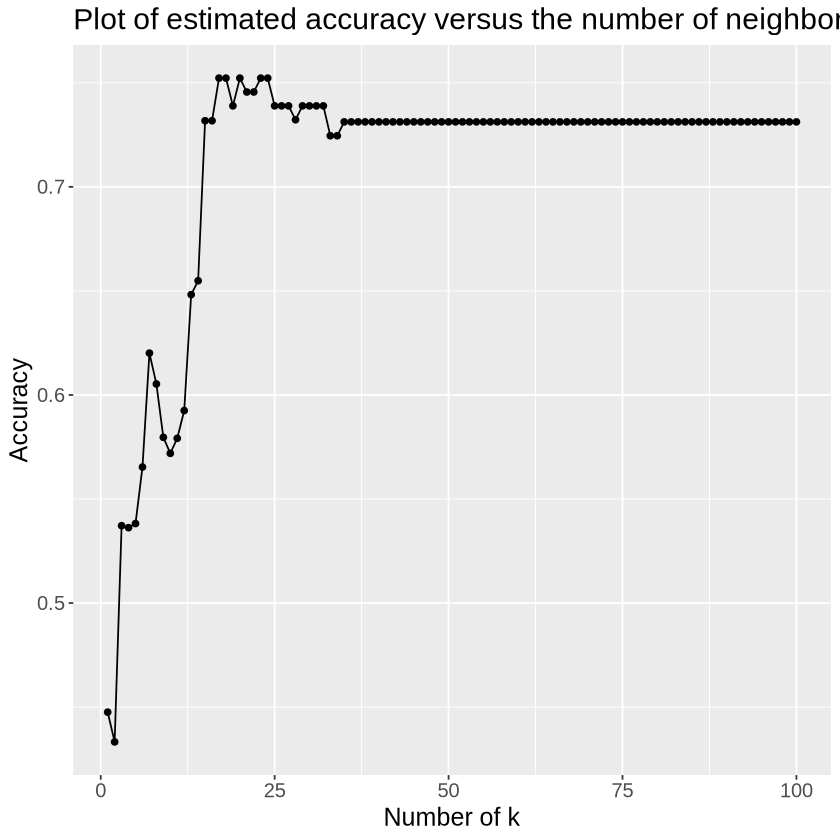

In [25]:
best_k_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    xlab("Number of k") +
    ylab("Accuracy") +
    ggtitle("Plot of estimated accuracy versus the number of neighbors") +
    theme(text = element_text(size = 15))

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k_plot
best_k

V-fold cross validation was also done to furthur improve our model. Accuracies of the model using different v-folds were compared, and revealed that a 10 fold cross validation resulted in higher accuracy and lower standard error relative to the 5-fold. 

In [26]:
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

vfold_5 <- vfold_cv(train, v = 5, strata = subscribe)

vfold_5_fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_new) |>
    fit_resamples(resamples = vfold_5)

vfold_5_metrics <- vfold_5_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

vfold_5_metrics

vfold_10_fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_new) |>
    fit_resamples(resamples = p_vfold)

vfold_10_metrics <- vfold_10_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

vfold_10_metrics

.metric  .estimator mean     n std_err    .config             
1 accuracy binary     0.738046 5 0.01692858 Preprocessor1_Model1

.metric  .estimator mean      n  std_err    .config             
1 accuracy binary     0.7522344 10 0.01458053 Preprocessor1_Model1

The quality metrics for the final tuned model was found. Accuracy was 73.5%, Precision was also 73.5% and Recall was 100%. Relatively high metrics were obtained, especially a rcall of 100% which we could fully trust the model to find players who are subscribed.

In [27]:
knn_fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_new) |>
    fit(data = train)

p_predictions <- predict(knn_fit, test) |>
  bind_cols(test)

prediction_accuracy <- p_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

prediction_precision <- p_predictions|>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_recall <- p_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# prediction_labels <- p_predictions |> 
#    pull(subscribe) |> 
#    levels()

prediction_accuracy
prediction_precision
prediction_recall

.metric  .estimator .estimate
1 accuracy binary     0.7346939

.metric   .estimator .estimate
1 precision binary     0.7346939

.metric .estimator .estimate
1 recall  binary     1

The confusion matrix reveals how 0 FALSE observations (not subscribed) were correctly classified as FALSE, and 36 TRUE (subscribed) observations were correctly classified as TRUE. However, it classified 13 FALSE observations to TRUE.

In [28]:
confusion <- p_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

Plotting the trained test data visualizes how the classifer always classifies the status of the supsription to "TRUE", indicating that a player will always subscribe to the newsletter. This is likely do to undersampling, where one variable is more common than the other. 

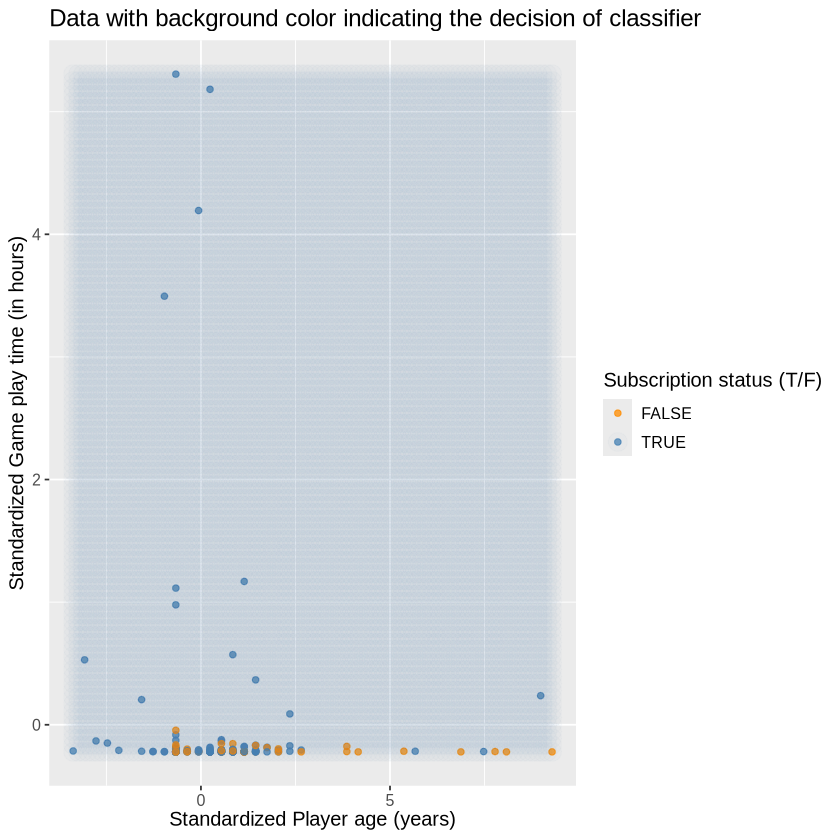

In [35]:
recipes <- recipe(subscribe ~ played_hours + age, data = test) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()
scaled_players <- bake(recipes, players)

are_grid <- seq(min(scaled_players$age),
                max(scaled_players$age),
                length.out = 100)
smo_grid <- seq(min(scaled_players$played_hours),
                max(scaled_players$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(age = are_grid,
                                played_hours = smo_grid))

knnPredGrid <- predict(knn_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(subscribe = .pred_class)

wkflw_plot <-
  ggplot() +
  geom_point(data = scaled_players,
             mapping = aes(x = age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.02,
             size = 5) +
  labs(color = "Subscription status (T/F)",
       x = "Standardized Player age (years)",
       y = "Standardized Game play time (in hours)", title = "Data with background color indicating the decision of classifier") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

wkflw_plot

## Discussion:
1. What was found
2. Is this what was expected to find
3. Discuss what impact could such findings have
4. What future questions could this lead to

Data analysis using our Knn classifier found that play hours and player age cannot accurately predict whether a player will subscribe to the newsletter or not. Based on the plot above, although the model accuracy and precision was over 70% with a recall of 100%, it would always classify a player as likely to subscribe. 

## References: optional
(Apa citation I think)